In [1]:
import numpy as np
import numpy.random as random
import matplotlib.pyplot as plt

In [2]:
#testing parallel run of shorter simulations for Gershman 2012's model, p is the number of simulations to run in parallel

In [3]:
def p_w_new(index,w,x_l,x_r,pi_l,pi_r,beta,var_l,var_r,b,tau,p):
    #index: the index of the weight to be sampled, tuple (i,j)
    #var_1: right mode; var_0: left mode
    i,j = index[0],index[1]
    s_n = w[:,i,j]*x_l[:,i,j]+(1-w[:,i,j])*x_r[:,i,j]
    E_s = (b[:,i,j]-s_n)**2
    w_extended = np.concatenate((w[:,:,0].reshape(p,-1,1),w,w[:,:,-1].reshape(p,-1,1)),axis=2)
    w_extended = np.concatenate((w_extended[:,0,:].reshape(p,1,-1),w_extended,w_extended[:,-1,:].reshape(p,1,-1)),axis=1)
    E_s = E_s + beta*((w_extended[:,i+1,j+1]-w_extended[:,i,j+1])**2+(w_extended[:,i+1,j+1]-w_extended[:,i+1,j])**2)
    E_s = E_s + beta*((w_extended[:,i+1,j+1]-w_extended[:,i+2,j+1])**2+(w_extended[:,i+1,j+1]-w_extended[:,i+1,j+2])**2)
    E_x = 1/(2*var_l)*pi_l[:,i,j]*(x_l[:,i,j]-s_n)**2+1/(2*var_r)*pi_r[:,i,j]*(x_r[:,i,j]-s_n)**2
    return np.exp(-tau*(E_x+E_s))

In [4]:
def p_pi_l_new(index,w,x_l,x_r,pi_l,pi_r,var_l,b,tau,gamma,p):
    #sparse coefficient alpha TBC
    i,j = index[0],index[1]
    s_n = w[:,i,j]*x_l[:,i,j]+(1-w[:,i,j])*x_r[:,i,j]
    E_xl = 1/(2*var_l)*pi_l[:,i,j]*(x_l[:,i,j]-s_n)**2
    pi_extended = np.concatenate((pi_l[:,:,0].reshape(p,-1,1),pi_l,pi_l[:,:,-1].reshape(p,-1,1)),axis=2)
    pi_extended = np.concatenate((pi_extended[:,0,:].reshape(p,1,-1),pi_extended,pi_extended[:,-1,:].reshape(p,1,-1)),axis=1)
    #E_pi_l = alpha*(pi_extended[i+2,j+1]+pi_extended[i+1,j+2]+pi_extended[i,j+1]+pi_extended[i+1,j])
    '''E_pi_l = E_pi_l + gamma*((pi_extended[:,i+1,j+1]-pi_extended[:,i,j+1])**2+(pi_extended[:i+1,j+1]-pi_extended[:,i+1,j])**2)'''
    E_pi_l = gamma*((pi_extended[:,i+1,j+1]-pi_extended[:,i,j+1])**2+(pi_extended[:,i+1,j+1]-pi_extended[:,i+1,j])**2)
    E_pi_l = E_pi_l + gamma*((pi_extended[:,i+1,j+1]-pi_extended[:,i+2,j+1])**2+(pi_extended[:,i+1,j+1]-pi_extended[:,i+1,j+2])**2)
    return np.exp(-tau*(E_xl+E_pi_l))*(1+np.sign(pi_l[:,i,j]+pi_r[:,i,j]-0.5))/2+1e-50

In [5]:
def p_pi_r_new(index,w,x_l,x_r,pi_l,pi_r,var_r,b,tau,gamma,p):
    #sparse coefficient alpha TBC
    i,j = index[0],index[1]
    s_n = w[:,i,j]*x_l[:,i,j]+(1-w[:,i,j])*x_r[:,i,j]
    E_xr = 1/(2*var_r)*pi_r[:,i,j]*(x_r[:,i,j]-s_n)**2
    pi_extended = np.concatenate((pi_r[:,:,0].reshape(p,-1,1),pi_r,pi_r[:,:,-1].reshape(p,-1,1)),axis=2)
    pi_extended = np.concatenate((pi_extended[:,0,:].reshape(p,1,-1),pi_extended,pi_extended[:,-1,:].reshape(p,1,-1)),axis=1)
    #E_pi_l = alpha*(pi_extended[i+2,j+1]+pi_extended[i+1,j+2]+pi_extended[i,j+1]+pi_extended[i+1,j])
    '''E_pi_l = E_pi_l + gamma*((pi_extended[:,i+1,j+1]-pi_extended[:,i,j+1])**2+(pi_extended[:i+1,j+1]-pi_extended[:,i+1,j])**2)'''
    E_pi_r = gamma*((pi_extended[:,i+1,j+1]-pi_extended[:,i,j+1])**2+(pi_extended[:,i+1,j+1]-pi_extended[:,i+1,j])**2)
    E_pi_r = E_pi_r + gamma*((pi_extended[:,i+1,j+1]-pi_extended[:,i+2,j+1])**2+(pi_extended[:,i+1,j+1]-pi_extended[:,i+1,j+2])**2)
    return np.exp(-tau*(E_xr+E_pi_r))*(1+np.sign(pi_l[:,i,j]+pi_r[:,i,j]-0.5))/2+1e-50

In [6]:
def proposal_function_new(z, index, p, sigma = 1):
    #generate a new proposal from the current sample
    #change only one element at a time!
    z_star = z.copy()
    i,j = index[0],index[1]
    z_star[:,i,j] = z_star[:,i,j] + sigma*random.normal(size = (p))
    return z_star

In [7]:
def binary_proposal_new(z,index):
    #p: the probability of switch, to stablize the system
    z_star = z.copy()
    z_star[:,index[0],index[1]] = 1-z[:,index[0],index[1]]
    return z_star

In [8]:
def sample_rejection_w_new(index,w,w_star,x_l,x_r,pi_l,pi_r,beta,var_l,var_r,b,tau,p):
    p_w_cur = p_w_new(index,w,x_l,x_r,pi_l,pi_r,beta,var_l,var_r,b,tau,p)
    p_w_star = p_w_new(index,w_star,x_l,x_r,pi_l,pi_r,beta,var_l,var_r,b,tau,p)
    p_acc = p_w_star/p_w_cur
    p_ran = random.random(p)
    acc = np.sign(p_acc-p_ran).astype('int')
    return acc
    
def sample_rejection_pi_l_new(index,w,x_l,x_r,pi_l,pi_l_star,pi_r,var_l,b,tau,gamma,p):
    p_pi_l_cur = p_pi_l_new(index,w,x_l,x_r,pi_l,pi_r,var_l,b,tau,gamma,p)
    p_pi_l_star = p_pi_l_new(index,w,x_l,x_r,pi_l_star,pi_r,var_l,b,tau,gamma,p)
    p_acc = p_pi_l_star/p_pi_l_cur
    p_ran = random.random(p)
    acc = np.sign(p_acc-p_ran).astype('int')
    return acc
    
def sample_rejection_pi_r_new(index,w,x_l,x_r,pi_l,pi_r,pi_r_star,var_r,b,tau,gamma,p):
    p_pi_r_cur = p_pi_r_new(index,w,x_l,x_r,pi_l,pi_r,var_r,b,tau,gamma,p)
    p_pi_r_star = p_pi_r_new(index,w,x_l,x_r,pi_l,pi_r_star,var_r,b,tau,gamma,p)
    p_acc = p_pi_r_star/p_pi_r_cur
    p_ran = random.random(p)
    acc = np.sign(p_acc-p_ran).astype('int')
    return acc

In [9]:
def simulation_new(var_l,var_r,beta,gamma,alpha,tau,b,dim,p,no_sample):
    #p: no. parallel sampling sequences
    #no. sample: no. samples in each sequence
    #dim: dimension of each MRF
    sampling_order_i = np.arange(dim)
    sampling_order_j = np.arange(dim)

    #set initial condition for w, pi_r, pi_l
    #set visual input x_r, x_l as conflicting input
    x_l = np.ones((p,dim,dim))
    x_r = np.zeros((p,dim,dim))
    w = random.rand(p,dim,dim)
    pi_l = random.randint(0,2,(p,dim,dim))
    pi_r = random.randint(0,2,(p,dim,dim))

    s = []
    pi_l_l = []
    pi_r_l = []
    for m in range(int(no_sample)):
        #order of sweep is randomnized
        random.shuffle(sampling_order_i)
        random.shuffle(sampling_order_j)
        #the following for loop update on pi_l
        for i in sampling_order_i:
            for j in sampling_order_j:
                index = (i,j)
                pi_r_star = binary_proposal_new(pi_r, index)
                acc_1 = sample_rejection_pi_r_new(index,w,x_l,x_r,pi_l,pi_r,pi_r_star,var_r,b,tau,gamma,p)
                for j in range(p):
                    if acc_1[j] == 1:
                        pi_r[j,:,:] = pi_r_star[j,:,:]

        #the following for loop update on pi_r
        for i in sampling_order_i:
            for j in sampling_order_j:
                index = (i,j)
                pi_l_star = binary_proposal_new(pi_l, index)
                acc_2 = sample_rejection_pi_l_new(index,w,x_l,x_r,pi_l,pi_l_star,pi_r,var_l,b,tau,gamma,p)
                for j in range(p):
                    if acc_2[j] == 1:
                        pi_l[j,:,:] = pi_l_star[j,:,:]
    
            #the following for loop update on w
            for i in sampling_order_i:
                for j in sampling_order_j:
                    index = (i,j)
                    w_star = proposal_function_new(w, index, p)
                    acc_3 = sample_rejection_w_new(index,w,w_star,x_l,x_r,pi_l,pi_r,beta,var_l,var_r,b,tau,p)
                    for j in range(p):
                        if acc_3[j] == 1:
                            w[j,:,:] = w_star[j,:,:]
        
        s_i = w*x_l+(1-w)*x_r
        s.append(s_i)
        pi_l_a = pi_l.copy()
        pi_r_a = pi_r.copy()
        pi_l_l.append(pi_l_a)
        pi_r_l.append(pi_r_a)
    return np.array(s),pi_l_l,pi_r_l

In [10]:
#from node's state to the no. node > 0.5 in each step
def node_count(s,p,no_sample):
    state_no_array = []
    for i in range(p):
        state_no_array_i = []
        for j in range(no_sample):
            state_no_array_i.append(len(np.where(s[j,i,:,:]>0.5)[0]))
        state_no_array.append(state_no_array_i)
    state_no_array = np.array(state_no_array)
    return state_no_array

In [11]:
def domi_period_count(state_list_input,dim):
    cross_list = []
    #element in cross list: (index,cross_type)
    #cross type = 1: upper bound going up
    #cross type = 2: lower bound going down
    for i in range(1,len(state_list_input)):
        if state_list_input[i-1]>dim**2*0.1 and state_list_input[i]<dim**2*0.1:
            cross_list.append((i,2))
        elif state_list_input[i-1]<dim**2*0.9 and state_list_input[i]>dim**2*0.9:
            cross_list.append((i,1))
    switch_list = [cross_list[0]]
    cross = cross_list[0][1]
    for i in range(1,len(cross_list)):
        if cross_list[i][1] != cross:
            cross = cross_list[i][1]
            switch_list.append(cross_list[i])
    domi_list =[]
    for i in range(1,len(switch_list)):
        domi_list.append(switch_list[i][0]-switch_list[i-1][0])
    return domi_list

def hist_plot(x,n):
    plt.hist(x,n)
    return np.mean(x),np.std(x)

def generate_domi_list(state_count,dim):
    domi_list = []
    for state_list_i in state_count:
        domi_list_i = domi_period_count(state_list_i,dim)
        domi_list = domi_list + domi_list_i
    return domi_list

In [12]:
def domi_period_count_new(state_list_input,dim):
    cross_list = []
    #element in cross list: (index,cross_type)
    #cross type = 1: upper bound going up
    #cross type = 2: lower bound going down
    for i in range(1,len(state_list_input)):
        if state_list_input[i-1]>0.1*dim**2 and state_list_input[i]<0.1*dim**2:
            cross_list.append((i,2))
        elif state_list_input[i-1]<0.9*dim**2 and state_list_input[i]>0.9*dim**2:
            cross_list.append((i,1))
    switch_list = [cross_list[0]]
    cross = cross_list[0][1]
    for i in range(1,len(cross_list)):
        if cross_list[i][1] != cross:
            cross = cross_list[i][1]
            switch_list.append(cross_list[i])
    domi_list =[]
    percept_list = []
    for i in range(1,len(switch_list)):
        domi_list.append(switch_list[i][0]-switch_list[i-1][0])
        percept_list.append(switch_list[i-1][1])
    return domi_list,percept_list

def generate_domi_percept_list(state_count,dim):
    domi_list = []
    percept_list = []
    for state_list_i in state_count:
        domi_list_i,percept_list_i = domi_period_count_new(state_list_i,dim)
        domi_list = domi_list + domi_list_i
        percept_list = percept_list+percept_list_i
    return domi_list,percept_list

In [13]:
def predomi_count(domi_period,domi_percept):
    domi_1 = 0
    domi_2 = 0
    for i in range(len(domi_period)):
        if domi_percept[i] == 1:
            domi_1 = domi_1 + domi_period[i]
        else:
            domi_2 = domi_2 + domi_period[i]
    return domi_1/np.sum(domi_period),domi_2/np.sum(domi_period)

def ave_domi_count(domi_period,domi_percept):
    domi_1_t = 0
    domi_2_t = 0
    domi_1_count = 0
    domi_2_count = 0
    for i in range(len(domi_period)):
        if int(domi_percept[i]) == 1:
            domi_1_t = domi_1_t + domi_period[i]
            domi_1_count = domi_1_count +1
        else:
            domi_2_t = domi_2_t + domi_period[i]
            domi_2_count = domi_2_count +1
    return domi_1_t/domi_1_count, domi_2_t/domi_2_count

In [14]:
def pi_count(pi_l,pi_r):
    pi_lr_00 = 0
    pi_lr_01 = 0
    pi_lr_10 = 0
    pi_lr_11 = 0
    for i in range(len(pi_l)):
        if pi_l[i]==0 and pi_r[i]==0:
            pi_lr_00 +=1
        if pi_l[i]==0 and pi_r[i]==1:
            pi_lr_01 +=1
        if pi_l[i]==1 and pi_r[i]==0:
            pi_lr_10 +=1
        if pi_l[i]==1 and pi_r[i]==1:
            pi_lr_11 +=1
    return pi_lr_00/len(pi_l),pi_lr_01/len(pi_l),pi_lr_10/len(pi_l),pi_lr_11/len(pi_l)

In [42]:
var_l,var_r,beta,gamma,alpha,tau,b,dim,p,no_sample = 0.001,0.001,10,10,0,1/100,0.5*np.ones((100,5,5)),5,100,4400
s_0001_0001, pi_l_l_0001_0001, pi_r_l_0001_0001 = simulation_new(var_l,var_r,beta,gamma,alpha,tau,b,dim,p,no_sample)
print('done')

var_l,var_r,beta,gamma,alpha,tau,b,dim,p,no_sample = 0.0025,0.0025,10,10,0,1/100,0.5*np.ones((100,5,5)),5,100,4400
s_00025_00025, pi_l_l_00025_00025, pi_r_l_00025_00025 = simulation_new(var_l,var_r,beta,gamma,alpha,tau,b,dim,p,no_sample)
print('done')

var_l,var_r,beta,gamma,alpha,tau,b,dim,p,no_sample = 0.005,0.005,10,10,0,1/100,0.5*np.ones((100,5,5)),5,100,4400
s_0005_0005, pi_l_l_0005_0005, pi_r_l_0005_0005 = simulation_new(var_l,var_r,beta,gamma,alpha,tau,b,dim,p,no_sample)
print('done')

var_l,var_r,beta,gamma,alpha,tau,b,dim,p,no_sample = 0.0005,0.0005,10,10,0,1/100,0.5*np.ones((100,5,5)),5,100,4400
s_00005_00005, pi_l_l_00005_00005, pi_r_l_00005_00005 = simulation_new(var_l,var_r,beta,gamma,alpha,tau,b,dim,p,no_sample)
print('done')

var_l,var_r,beta,gamma,alpha,tau,b,dim,p,no_sample = 0.00025,0.00025,10,10,0,1/100,0.5*np.ones((100,5,5)),5,100,4400
s_000025_000025, pi_l_l_000025_000025, pi_r_l_000025_000025 = simulation_new(var_l,var_r,beta,gamma,alpha,tau,b,dim,p,no_sample)
print('done')

var_l,var_r,beta,gamma,alpha,tau,b,dim,p,no_sample = 0.0001,0.0001,10,10,0,1/100,0.5*np.ones((100,5,5)),5,100,4400
s_00001_00001, pi_l_l_00001_00001, pi_r_l_00001_00001 = simulation_new(var_l,var_r,beta,gamma,alpha,tau,b,dim,p,no_sample)

done
done
done
done
done


(0.0, 0.5139987272727272, 0.48598836363636366, 1.2909090909090908e-05)


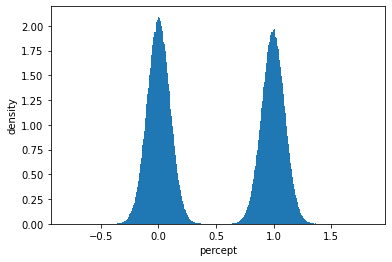

In [35]:
plt.hist(np.array(s_00001_00001).reshape(-1),1000,density=True)
plt.xlabel('percept')
plt.ylabel('density')
print(pi_count(np.array(pi_l_l_00001_00001).reshape(-1),np.array(pi_r_l_00001_00001).reshape(-1)))

In [43]:
print(pi_count(np.array(pi_l_l_0001_0001).reshape(-1),np.array(pi_r_l_0001_0001).reshape(-1)))
print(pi_count(np.array(pi_l_l_00025_00025).reshape(-1),np.array(pi_r_l_00025_00025).reshape(-1)))
print(pi_count(np.array(pi_l_l_0005_0005).reshape(-1),np.array(pi_r_l_0005_0005).reshape(-1)))
print(pi_count(np.array(pi_l_l_00005_00005).reshape(-1),np.array(pi_r_l_00005_00005).reshape(-1)))
print(pi_count(np.array(pi_l_l_000025_000025).reshape(-1),np.array(pi_r_l_000025_000025).reshape(-1)))
print(pi_count(np.array(pi_l_l_00001_00001).reshape(-1),np.array(pi_r_l_00001_00001).reshape(-1)))

(0.0, 0.4842858181818182, 0.48550563636363636, 0.030208545454545453)
(0.0, 0.43558345454545455, 0.4368007272727273, 0.1276158181818182)
(0.0, 0.3988816363636364, 0.3991613636363636, 0.201957)
(0.0, 0.4999599090909091, 0.49752836363636366, 0.0025117272727272727)
(0.0, 0.5095927272727273, 0.49038, 2.7272727272727273e-05)
(0.0, 0.4967996363636364, 0.5031939090909091, 6.454545454545454e-06)


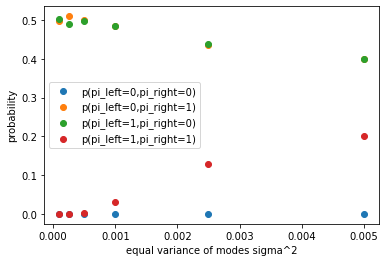

In [44]:
plt.scatter(np.array([0.001,0.0025,0.005,0.0005,0.00025,0.0001]),np.array([0,0,0,0,0,0]))
plt.scatter(np.array([0.001,0.0025,0.005,0.0005,0.00025,0.0001]),np.array([0.4843,0.4356,0.3989,0.5000,0.5096,0.4968]))
plt.scatter(np.array([0.001,0.0025,0.005,0.0005,0.00025,0.0001]),np.array([0.4855,0.4368,0.3992,0.4975,0.4904,0.5032]))
plt.scatter(np.array([0.001,0.0025,0.005,0.0005,0.00025,0.0001]),np.array([0.03,0.128,0.2019,0.0025,3e-5,6e-5]))
plt.xlabel('equal variance of modes sigma^2')
plt.ylabel('probability')
plt.legend(['p(pi_left=0,pi_right=0)','p(pi_left=0,pi_right=1)','p(pi_left=1,pi_right=0)','p(pi_left=1,pi_right=1)'])

In [47]:
var_l,var_r,beta,gamma,alpha,tau,b,dim,p,no_sample = 0.0025,0.001,10,10,0,1/100,0.5*np.ones((100,5,5)),5,100,4400
s_00025_0001, pi_l_l_00025_0001, pi_r_l_00025_0001 = simulation_new(var_l,var_r,beta,gamma,alpha,tau,b,dim,p,no_sample)

var_l,var_r,beta,gamma,alpha,tau,b,dim,p,no_sample = 0.005,0.001,10,10,0,1/100,0.5*np.ones((100,5,5)),5,100,4400
s_0005_0001, pi_l_l_0005_0001, pi_r_l_0005_0001 = simulation_new(var_l,var_r,beta,gamma,alpha,tau,b,dim,p,no_sample)

var_l,var_r,beta,gamma,alpha,tau,b,dim,p,no_sample = 0.0005,0.001,10,10,0,1/100,0.5*np.ones((100,5,5)),5,100,4400
s_00005_0001, pi_l_l_00005_0001, pi_r_l_00005_0001 = simulation_new(var_l,var_r,beta,gamma,alpha,tau,b,dim,p,no_sample)

var_l,var_r,beta,gamma,alpha,tau,b,dim,p,no_sample = 0.00025,0.001,10,10,0,1/100,0.5*np.ones((100,5,5)),5,100,4400
s_000025_0001, pi_l_l_000025_0001, pi_r_l_000025_0001 = simulation_new(var_l,var_r,beta,gamma,alpha,tau,b,dim,p,no_sample)

var_l,var_r,beta,gamma,alpha,tau,b,dim,p,no_sample = 0.0001,0.001,10,10,0,1/100,0.5*np.ones((100,5,5)),5,100,4400
s_00001_0001, pi_l_l_00001_0001, pi_r_l_00001_0001 = simulation_new(var_l,var_r,beta,gamma,alpha,tau,b,dim,p,no_sample)

In [48]:
print(pi_count(np.array(pi_l_l_0001_0001).reshape(-1),np.array(pi_r_l_0001_0001).reshape(-1)))
print(pi_count(np.array(pi_l_l_00025_0001).reshape(-1),np.array(pi_r_l_00025_0001).reshape(-1)))
print(pi_count(np.array(pi_l_l_0005_0001).reshape(-1),np.array(pi_r_l_0005_0001).reshape(-1)))
print(pi_count(np.array(pi_l_l_00005_0001).reshape(-1),np.array(pi_r_l_00005_0001).reshape(-1)))
print(pi_count(np.array(pi_l_l_000025_0001).reshape(-1),np.array(pi_r_l_000025_0001).reshape(-1)))
print(pi_count(np.array(pi_l_l_00001_0001).reshape(-1),np.array(pi_r_l_00001_0001).reshape(-1)))

(0.0, 0.4842858181818182, 0.48550563636363636, 0.030208545454545453)
(0.0, 0.31923172727272725, 0.6045780909090909, 0.07619018181818182)
(0.0, 0.23599336363636364, 0.6503834545454545, 0.11362318181818182)
(0.0, 0.624898, 0.36292772727272726, 0.012174272727272728)
(0.0, 0.7435595454545455, 0.25145690909090906, 0.004983545454545455)
(0.0, 0.8431464545454546, 0.15491245454545455, 0.001941090909090909)


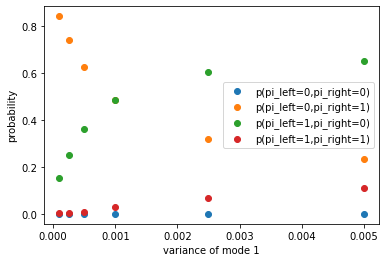

In [50]:
plt.scatter(np.array([0.001,0.0025,0.005,0.0005,0.00025,0.0001]),np.array([0,0,0,0,0,0]))
plt.scatter(np.array([0.001,0.0025,0.005,0.0005,0.00025,0.0001]),np.array([0.4843,0.3192,0.2360,0.6249,0.7436,0.8431]))
plt.scatter(np.array([0.001,0.0025,0.005,0.0005,0.00025,0.0001]),np.array([0.4855,0.6046,0.6504,0.3629,0.2514,0.1549]))
plt.scatter(np.array([0.001,0.0025,0.005,0.0005,0.00025,0.0001]),np.array([0.03,0.07,0.11,0.01,0.004,0.002]))
plt.xlabel('variance of mode 1')
plt.ylabel('probability')
plt.legend(['p(pi_left=0,pi_right=0)','p(pi_left=0,pi_right=1)','p(pi_left=1,pi_right=0)','p(pi_left=1,pi_right=1)'])

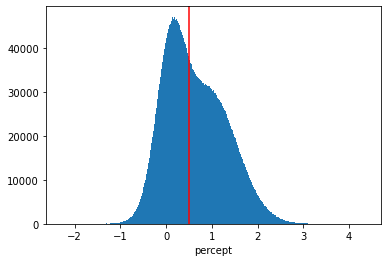

In [56]:
plt.hist(s_0005_0001.reshape(-1),1000)
plt.xlabel('percept')
plt.axvline(x=0.5,color='r')

In [62]:
len(np.where(s_00001_0001.reshape(-1)>0.5)[0])/len(s_0005_0001.reshape(-1))

0.20317454545454544